<a href="https://colab.research.google.com/github/CMedrado/Topicosemcomputa-o/blob/main/Mozzila_total.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Texto no contexto da Predição de Severidade de Bug Reports

Exemplo de classificação de texto com pipeline de NLP e classificador no final

In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [2]:
# Tokenização
def tokenize(text):
    # Tokenização
    tokens = nltk.word_tokenize(text)
    
    # Stemização
    stems  = []
    for item in tokens:
        stems.append(SnowballStemmer("english").stem(item))
    return stems

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Carregando os dados
df = pd.read_csv('/content/drive/My Drive/TP/PF/Dataset (1)/Mozilla_total.csv') # Salvamos com esse nome antes

# Dataset
df.head(11)

,Bug_report_ID,Product_Name,summary,description,component_name,severity_level,priority,assignee_developers,topic_id,status
0,1077381,Firefox for Android,android nightli fail unicodeencodeerror ascii ...,http treeherder mozilla org ui logviewer html ...,Build Config & IDE Support,blocker,--,nalexander,emorley tbplbot tbplbot l10n nalexander l10n n...,FIXED
1,843997,Firefox for Android,mobil websit correctli display,creat attach log firefox mobil beta aurora a s...,"Graphics, Panning and Zooming",blocker,--,nobody,adriant.mozilla adriant.mozilla catalin.suciu ...,FIXED
2,854289,Firefox for Android,dynam toolbar activ html element map shift aff...,creat attach annot screenshot dynam toolbar en...,"Graphics, Panning and Zooming",blocker,--,chrislord.net,nirvn.asia nirvn.asia gpascutto aaron.train aa...,FIXED
3,844020,Firefox for Android,swiftkey keyboard firefox android hang firefox...,user agent mozilla window nt wow rv gecko fire...,Keyboards and IME,critical,--,bugmail.mozilla,EddyCarr EddyCarr aaron.train bugmail.mozilla ...,FIXED
4,912173,Firefox for Android,crash mozilla refptr mozilla gl glcontext refptr,bug file socorro interfac report bp f a b a f ...,"Graphics, Panning and Zooming",critical,--,matt.woodrow,nchen jacob.benoit.1 milan nchen nchen matt.wo...,FIXED
5,870333,Firefox for Android,java lang nullpointerexcept android view input...,crash a bp c bc b ec a c ff b java lang nullpo...,Keyboards and IME,critical,--,briancecker,scoobidiver cpeterson briancecker cpeterson br...,FIXED
6,970096,Firefox for Android,crash mozilla gl glcontextprovideregl createfo...,bug file socorro interfac report bp b e eae aa...,"Graphics, Panning and Zooming",critical,--,snorp,kbrosnan snorp kbrosnan snorp snorp jacob.beno...,FIXED
7,1102946,Firefox for Android,crash java lang nullpointerexcept org mozilla ...,bug file socorro interfac report bp b f d f a ...,Data Providers,critical,--,rnewman,aaron.train rnewman kbrosnan rnewman,FIXED
8,827176,Firefox for Android,java lang nullpointerexcept org mozilla gecko ...,crash a a crash report bp fa a eaf b java lang...,Keyboards and IME,critical,--,nchen,scoobidiver nchen cpeterson nchen ryanvm nchen...,FIXED
9,866032,Firefox for Android,java lang nullpointerexcept org mozilla gecko ...,s crash a bp bffe b d dc a a java lang nullpoi...,"Graphics, Panning and Zooming",critical,--,nobody,scoobidiver bugmail.mozilla,FIXED


In [5]:
df['severity_level'].value_counts()

normal         15226
enhancement      865
minor            711
major            705
critical         532
trivial          463
blocker          291
Name: severity_level, dtype: int64

In [6]:
class_names = df['severity_level'].unique()
class_names

array(['blocker', 'critical', 'major', 'normal', 'minor', 'trivial',
       'enhancement'], dtype=object)

In [7]:
status_names = df['status'].unique() 
status_names

array(['FIXED'], dtype=object)

In [8]:
#Convertendo 'summary' e 'description' para string
df = df.astype({'summary':'str', 'description':'str'})

In [9]:
#Filtrando severidades confiaveis
df = df.loc[(df['severity_level'] != 'enhancement') & (df['severity_level'] != 'normal')]

In [11]:
#Modificando severidade diferente de blocker (Classificação binaria)
df.loc[(df['severity_level'] != 'blocker'), 'severity_level'] = "no-blocker"

In [12]:
df['severity_level'].value_counts()

no-blocker    2411
blocker        291
Name: severity_level, dtype: int64

In [13]:
df.head(11)

,Bug_report_ID,Product_Name,summary,description,component_name,severity_level,priority,assignee_developers,topic_id,status
0,1077381,Firefox for Android,android nightli fail unicodeencodeerror ascii ...,http treeherder mozilla org ui logviewer html ...,Build Config & IDE Support,blocker,--,nalexander,emorley tbplbot tbplbot l10n nalexander l10n n...,FIXED
1,843997,Firefox for Android,mobil websit correctli display,creat attach log firefox mobil beta aurora a s...,"Graphics, Panning and Zooming",blocker,--,nobody,adriant.mozilla adriant.mozilla catalin.suciu ...,FIXED
2,854289,Firefox for Android,dynam toolbar activ html element map shift aff...,creat attach annot screenshot dynam toolbar en...,"Graphics, Panning and Zooming",blocker,--,chrislord.net,nirvn.asia nirvn.asia gpascutto aaron.train aa...,FIXED
3,844020,Firefox for Android,swiftkey keyboard firefox android hang firefox...,user agent mozilla window nt wow rv gecko fire...,Keyboards and IME,no-blocker,--,bugmail.mozilla,EddyCarr EddyCarr aaron.train bugmail.mozilla ...,FIXED
4,912173,Firefox for Android,crash mozilla refptr mozilla gl glcontext refptr,bug file socorro interfac report bp f a b a f ...,"Graphics, Panning and Zooming",no-blocker,--,matt.woodrow,nchen jacob.benoit.1 milan nchen nchen matt.wo...,FIXED
5,870333,Firefox for Android,java lang nullpointerexcept android view input...,crash a bp c bc b ec a c ff b java lang nullpo...,Keyboards and IME,no-blocker,--,briancecker,scoobidiver cpeterson briancecker cpeterson br...,FIXED
6,970096,Firefox for Android,crash mozilla gl glcontextprovideregl createfo...,bug file socorro interfac report bp b e eae aa...,"Graphics, Panning and Zooming",no-blocker,--,snorp,kbrosnan snorp kbrosnan snorp snorp jacob.beno...,FIXED
7,1102946,Firefox for Android,crash java lang nullpointerexcept org mozilla ...,bug file socorro interfac report bp b f d f a ...,Data Providers,no-blocker,--,rnewman,aaron.train rnewman kbrosnan rnewman,FIXED
8,827176,Firefox for Android,java lang nullpointerexcept org mozilla gecko ...,crash a a crash report bp fa a eaf b java lang...,Keyboards and IME,no-blocker,--,nchen,scoobidiver nchen cpeterson nchen ryanvm nchen...,FIXED
9,866032,Firefox for Android,java lang nullpointerexcept org mozilla gecko ...,s crash a bp bffe b d dc a a java lang nullpoi...,"Graphics, Panning and Zooming",no-blocker,--,nobody,scoobidiver bugmail.mozilla,FIXED


In [14]:
df.shape[0]

2702

In [15]:
# Stop Words

nltk.download('stopwords')

nltk.download('punkt')

stop_words = nltk.corpus.stopwords.words('english')

text_clf   = Pipeline([
                # Vectorize
                ('vect',  TfidfVectorizer(tokenizer=tokenize, 
                                          stop_words=stop_words, 
                                          ngram_range=(1,1))),
                # Classificador
                ('clf',   KNeighborsClassifier(n_jobs=-5)),
            ])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Divididos em 11 quadros não sobrepostos de tamanhos iguais.

In [16]:
df_set = []
k = 245
for i in range(0,10):
  df_set.append(df.iloc[i*245:k])
  k += 245
  print("Quadro {}".format(i), "possui {} entradas.".format(df_set[i].shape[0]))

df_set.append(df.iloc[2450:2702])

print("Quadro 10 possui {} entradas.".format(df_set[10].shape[0]))

Quadro 0 possui 245 entradas.
Quadro 1 possui 245 entradas.
Quadro 2 possui 245 entradas.
Quadro 3 possui 245 entradas.
Quadro 4 possui 245 entradas.
Quadro 5 possui 245 entradas.
Quadro 6 possui 245 entradas.
Quadro 7 possui 245 entradas.
Quadro 8 possui 245 entradas.
Quadro 9 possui 245 entradas.
Quadro 10 possui 252 entradas.


In [17]:
X_test = []

for i in range(0, 10):
  new_df = df_set[0]
  for j in range(0, i):
    new_df = pd.merge(new_df, df_set[j+1], how = 'outer')
  X_test.append(new_df)

In [18]:
for i in range(0, len(X_test)):
  print("Treinamento {}, possui {} entradas.". format(i+1, X_test[i].shape[0]))

Treinamento 1, possui 245 entradas.
Treinamento 2, possui 490 entradas.
Treinamento 3, possui 735 entradas.
Treinamento 4, possui 980 entradas.
Treinamento 5, possui 1225 entradas.
Treinamento 6, possui 1470 entradas.
Treinamento 7, possui 1715 entradas.
Treinamento 8, possui 1960 entradas.
Treinamento 9, possui 2205 entradas.
Treinamento 10, possui 2450 entradas.


In [19]:
# Evaluate
for i in range(0, len(X_test)):
  text_clf = text_clf.fit(X_test[i].description, X_test[i].assignee_developers)
  pred = text_clf.predict(df_set[i+1].description)
  accuracy_scoreMLP_TFIDF = f1_score(df_set[i+1].assignee_developers, pred, average='micro')
  accuracy_scoreMLP_TFIDF

In [20]:

predictions = text_clf.predict(df_set[10].description)

conf_matrix = confusion_matrix(df_set[10].assignee_developers, predictions)

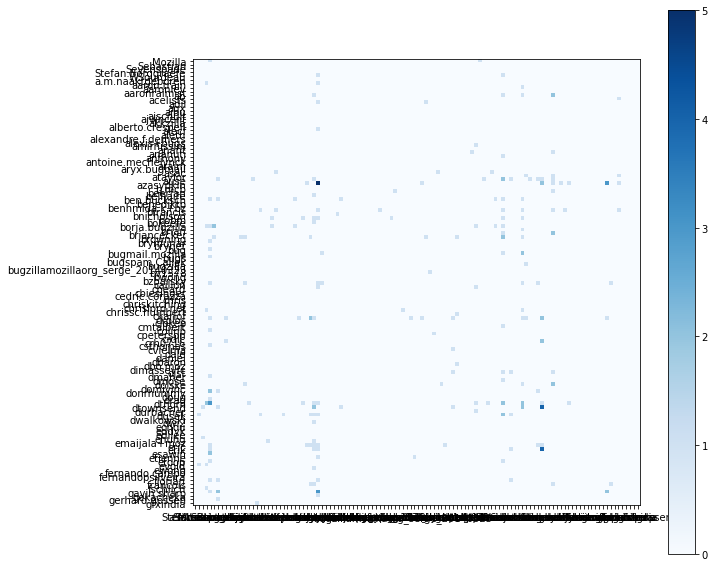

In [21]:
plt.figure(figsize=(10,10))
plt.xticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.yticks(np.arange(len(text_clf.classes_)),text_clf.classes_)
plt.imshow(conf_matrix,cmap=plt.cm.Blues)
plt.colorbar()